In [ ]:
# For google colab, mount Google drive where data is stored
from google.colab import drive
drive.mount('/content/drive')
import sys
# Add parent directory to path (one level up from training/)
sys.path.append('..')

Mounted at /content/drive


# Data visualization
It's helpful to build some intuition on the dataset we are using. This part can be seen in details at [../utils/dataset_introduction.ipynb](../utils/dataset_introduction.ipynb)

# Preprocess
Next, I'll preprocess the .nii.gz files to generate numerous .npy files, each corresponding 2D data.

Notice: In 'other' dataset, the labels are defined as:

liver (label=1), kidney (label=2), spleen (label=3), and pancreas (label=4)

But in pku dataset, the labels are defined as:

1: Bladder, 2: Colon, 3: Femur Head L, 4: Femur Head R, 5: Kidney L, 6: Kidney R, 7: Liver, 8: Rectum, 9: SmallIntestine, 10: SpinalCord, 11: Stomach

To simultaneously take advantage of both datasets, in the following process I'll rearrange the label files defined as:

0: Background, 1: Bladder, 2: Colon, 3: Femur Head, 4: Kidney, 5: Liver, 6: Rectum, 7: SmallIntestine, 8: SpinalCord, 9: Stomach, 10: Spleen, 11: Pancreas

Moreover, in order to implement weighted loss for training process, we need to record the frequency of each index and record a "distance map" along with images and masks. 

(Finally I didn't use the frequency of each index to determine the weights, though)

If there is already preprocessed .npy files. Then we can skip this part.

In [ ]:
# Preprocess PKU dataset using functions from preprocess_data.py
from utils.preprocess_data import preprocess_pku_dataset

# Define paths
output_base_path = '/content/processed_data/'
image_input_path = '/content/drive/MyDrive/med_segmentation/pku_train_dataset/ct/'
mask_input_path = '/content/drive/MyDrive/med_segmentation/pku_train_dataset/label/'

# Initialize label frequency dictionary (12 classes: 0-11)
label_frequency = {i: 0 for i in range(12)}

# Preprocess PKU dataset
label_frequency = preprocess_pku_dataset(
    image_input_path=image_input_path,
    mask_input_path=mask_input_path,
    output_base_path=output_base_path,
    label_frequency=label_frequency,
    min_clip_value=-400,
    max_clip_value=400,
    target_size=(256, 256),
    num_brightness_variations=4
)

print(f"\nLabel frequency after PKU dataset: {label_frequency}")

Starting processing of 72 image-mask pairs...
Processed 1/72: 1 (76 slices, 16 variations each)
Processed 2/72: 100 (93 slices, 16 variations each)
Processed 3/72: 102 (107 slices, 16 variations each)
Processed 4/72: 103 (111 slices, 16 variations each)
Processed 5/72: 105 (92 slices, 16 variations each)
Processed 6/72: 106 (107 slices, 16 variations each)
Processed 7/72: 107 (98 slices, 16 variations each)
Processed 8/72: 11 (74 slices, 16 variations each)
Processed 9/72: 12 (89 slices, 16 variations each)
Processed 10/72: 13 (81 slices, 16 variations each)
Processed 11/72: 14 (87 slices, 16 variations each)
Processed 12/72: 16 (80 slices, 16 variations each)
Processed 13/72: 17 (83 slices, 16 variations each)
Processed 14/72: 2 (89 slices, 16 variations each)
Processed 15/72: 20 (76 slices, 16 variations each)
Processed 16/72: 21 (72 slices, 16 variations each)
Processed 17/72: 22 (69 slices, 16 variations each)
Processed 18/72: 23 (69 slices, 16 variations each)
Processed 19/72: 25 

In [ ]:
# Preprocess 'Other' (AbdomenCT-1K) dataset using functions from preprocess_data.py
from utils.preprocess_data import preprocess_other_dataset

# Define paths for 'Other' dataset
image_input_path_other = '/content/drive/MyDrive/med_segmentation/other_train_dataset/Image/'
mask_input_path_other = '/content/drive/MyDrive/med_segmentation/other_train_dataset/Mask/'

# Preprocess Other dataset (continues updating label_frequency from PKU dataset)
label_frequency = preprocess_other_dataset(
    image_input_path=image_input_path_other,
    mask_input_path=mask_input_path_other,
    output_base_path=output_base_path,
    label_frequency=label_frequency,
    min_clip_value=-400,
    max_clip_value=400,
    target_size=(256, 256),
    num_brightness_variations=4
)

print(f"\nFinal label frequency after both datasets: {label_frequency}")

Starting processing of 41 image-mask pairs...
Processed 1/41: Case_00001_ (270 slices, 16 variations each)
Processed 2/41: Case_00002_ (64 slices, 16 variations each)
Processed 3/41: Case_00003_ (834 slices, 16 variations each)
Processed 4/41: Case_00004_ (157 slices, 16 variations each)
Processed 5/41: Case_00005_ (61 slices, 16 variations each)
Processed 6/41: Case_00006_ (227 slices, 16 variations each)
Processed 7/41: Case_00007_ (77 slices, 16 variations each)
Processed 8/41: Case_00008_ (50 slices, 16 variations each)
Processed 9/41: Case_00009_ (80 slices, 16 variations each)
Processed 10/41: Case_00011_ (92 slices, 16 variations each)
Processed 11/41: Case_00012_ (439 slices, 16 variations each)
Processed 12/41: Case_00014_ (32 slices, 16 variations each)
Processed 13/41: Case_00015_ (159 slices, 16 variations each)
Processed 14/41: Case_00017_ (85 slices, 16 variations each)
Processed 15/41: Case_00018_ (670 slices, 16 variations each)
Processed 16/41: Case_00019_ (96 slices, 

# Build dataset

Next, we can collect the .npy files into datasets and dataloaders for training.

In [ ]:
# Load and pair preprocessed files
from utils.dataset import load_and_pair_files

# Define the path to preprocessed data
# output_base_path = "/content/drive/Shareddrives/Yi Group/Members/Undergraduate research/MengyaoZhang/processed_data/"
output_base_path = '/content/processed_data/'

# Load and pair all image, mask, and distance map files
paired_file_paths = load_and_pair_files(output_base_path)

Found 241984 paired (image+mask+distance_map) files.


In [ ]:
# Create training and validation datasets
from utils.dataset import create_train_val_datasets

# Split data into train and validation sets
train_dataset, val_dataset = create_train_val_datasets(
    paired_file_paths, 
    test_size=0.2, 
    random_state=42
)

Number of training samples: 193587
Number of validation samples: 48397


# Build model
Build the U-net. Input: [Batch, 1, 512, 512]. Output: [Batch, 12, 512, 512]

In [4]:
# Import UNet model from network module
from network.Unet import UNet

print("UNet model imported successfully.")

UNet model imported successfully.


# Loss function and score function
I'll define the loss function. After numerous attempt, I finally didn't use DiceLoss.

IOU is intersection over union, and dice score is 2*intersection over sum. They are used to evaluate the accuracy, not loss.

During experiments, I realize that there is a fatal illness of dice score/iou score:
when calculating the score for a certain organ on a certain slice, it's likely that it's not labeled on ground truth masks. And if the model also doesn't predict it, then score is 1. Averaging over all slices will greatly overestimate the accuracy for this organ. Therefore, the score here returns the total number of intersecting pixels and union pixels/sum pixels, over the batch of inputs. 

In [ ]:
from utils.loss_and_metrics import WeightedCELoss, calculate_dice, calculate_iou

print("Loss functions and metrics imported successfully.")

# Training

In [ ]:
import torch.optim as optim
import wandb
import os
import datetime
from google.colab import userdata
from torch.amp import autocast, GradScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
if torch.cuda.is_available():
    os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
    scaler = GradScaler()
    torch.cuda.empty_cache()

run_name = f"unet-medical-seg-{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
num_classes = 12 # PKU dataset: 0-9 (background + 9 organs)
# When using both datasets: num_classes = 12 (0-11, including Spleen and Pancreas)

# 1. Initialize the UNet model and move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
  print('Using cuda\n')

# # Calculate class weights from the existing label_frequency dictionary
# if "label_frequency" not in globals():
#     raise ValueError("label_frequency must be computed first! Run the preprocessing cell.")

# # Compute inverse frequency weights for CrossEntropyLoss
# total_pixels = sum(label_frequency.values())
# class_weights_ce = []
# for i in range(num_classes):
#     if label_frequency[i] > 0:
#         # Inverse frequency normalized by total for numerical stability
#         weight = total_pixels / (num_classes * label_frequency[i])
#     else:
#         weight = 0.0 # Assign 0 or a very small number if a class has no pixels
#     class_weights_ce.append(weight)

# class_weights_ce = torch.tensor(class_weights_ce, dtype=torch.float32).to(device)
class_weights_ce = torch.tensor([0.3, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.6, 1.0, 1.0, 1.0, 1.0], dtype=torch.float32).to(device)
# print(f"Label frequencies: {label_frequency}")
print(f"Class weights for CrossEntropyLoss: {class_weights_ce.cpu().tolist()}")

# Define the loss functions
alpha21 = 10
sigma=3
criterion_ce1 = nn.CrossEntropyLoss(weight=class_weights_ce)
criterion_ce2 = WeightedCELoss(num_classes=num_classes, class_weights=class_weights_ce, sigma=sigma)

# Training parameters
features=[64, 128, 256, 512]  # When changing this, don't forget to also change that in visualization
num_epochs = 6 # You can adjust this
save_path = '/content/drive/MyDrive/med_segmentation/best_unet_model.pth'
best_loss = float('inf')

# GRADIENT ACCUMULATION PARAMETERS
gradient_accumulation_steps = 1
effective_batch_size = 64

if "min_clip_value" not in globals():  # Don't forget to change the clipping window in preprocessing
    min_clip_value = -400
if "max_clip_value" not in globals():
    max_clip_value = 400

# Update DataLoaders with smaller batch size
num_workers = 8  # Set to 0 to avoid prefetching memory
train_loader = DataLoader(train_dataset, batch_size=effective_batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=effective_batch_size, shuffle=False, num_workers=num_workers)

# Define the optimizer and scheduler WITHOUT gradient checkpointing (incompatible with mixed precision)
model = UNet(in_channels=1, out_channels=num_classes, features=features, use_checkpointing=False).to(device)
lr = 6e-4
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.2)

print(f"Training UNet model with gradient accumulation (steps={gradient_accumulation_steps}) and mixed precision...")
print(f"Effective batch size: {effective_batch_size * gradient_accumulation_steps}")
print("Note: Gradient checkpointing disabled due to incompatibility with mixed precision training")
print("Using Cross Entropy Loss with class weights for segmentation")

try:
  wandb_api_key = userdata.get("WANDB_API_KEY")
except:
  raise ValueError('Please set the API key in Colab Secrets!')
os.environ['WANDB_API_KEY'] = wandb_api_key

wandb.init(
    project="medical-segmentation",
    name=run_name,  # Unique name for each run
    config={
        "learning_rate": lr,
        "epochs": num_epochs,
        "batch_size": effective_batch_size,
        "gradient_accumulation_steps": gradient_accumulation_steps,
        "effective_batch_size": effective_batch_size * gradient_accumulation_steps,
        "features": features,
        "num_classes": num_classes,
        "optimizer": optimizer.__class__.__name__,
        "scheduler": scheduler.__class__.__name__,
        "loss_function": "two CrossEntropy",
        "ce_class_weights": class_weights_ce.cpu().tolist(),
        # "label_frequency": label_frequency,
        "gradient_checkpointing": False,
        "clip_value": [min_clip_value, max_clip_value],
        "batch_normalize": True,
        "alpha21": alpha21,
        "sigma": sigma
    })

N_record = 40  # log after each N_record batches






for epoch in range(num_epochs):
    # Training Phase
    model.train()
    running_loss_ce1 = 0.0
    running_loss_ce2 = 0.0
    running_loss_ce = 0.0
    running_iou_components = torch.zeros(num_classes - 1, 2, device=device)
    running_dice_components = torch.zeros(num_classes - 1, 2, device=device)

    # Reset gradients at the beginning of each accumulation cycle
    optimizer.zero_grad()

    for batch_idx, (images, masks, distance_maps) in enumerate(train_loader):
      # images (N,C,H,W)
      # masks (N,1,H,W)
      # distance_maps (N,1,H,W)
        images = images.to(device)
        masks = masks.to(device) # Masks are already long type from NPYDataset
        distance_maps = distance_maps.to(device)

        if torch.cuda.is_available():
            with autocast(device_type='cuda'):
                outputs = model(images)
                # self defined CrossEntropyLoss expects target shape (N, 1, H, W) instead of (N,H,W)
                loss_ce1 = criterion_ce1(outputs, masks.squeeze(1))
                loss_ce2 = criterion_ce2(outputs, masks, distance_maps)
                loss_ce = loss_ce1 + alpha21 * loss_ce2
                # Normalize the loss by the number of accumulation steps
                loss_ce = loss_ce / gradient_accumulation_steps

            scaler.scale(loss_ce).backward()
        else:
            outputs = model(images)
            loss_ce1 = criterion_ce1(outputs, masks.squeeze(1))
            loss_ce2 = criterion_ce2(outputs, masks, distance_maps)
            # Normalize the loss by the number of accumulation steps
            loss_ce = loss_ce1 + loss_ce2
            loss_ce = loss_ce / gradient_accumulation_steps
            loss_ce.backward()

        # Accumulate gradients, then step optimizer and clear gradients
        if (batch_idx + 1) % gradient_accumulation_steps == 0:
            if torch.cuda.is_available():
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad() # Clear gradients only after an optimizer step

        # To calculate the average loss over the N_record batches
        # Scale back loss for logging (multiply by accumulation_steps)
        running_loss_ce += loss_ce.item() * gradient_accumulation_steps
        running_loss_ce1 += loss_ce1.item()
        running_loss_ce2 += loss_ce2.item()
        running_iou_components += calculate_iou(outputs.detach(), masks.detach(), num_classes)
        running_dice_components += calculate_dice(outputs.detach(), masks.detach(), num_classes)

        # Adjust logging frequency to reflect effective batch size
        if (batch_idx + 1) % (N_record) == 0:
            # Calculate mean IoU and Dice scores
            # If union/total is zero, set score to 1.0
            iou_scores = torch.where(
                running_iou_components[:, 1] > 0,
                running_iou_components[:, 0] / running_iou_components[:, 1],
                torch.ones_like(running_iou_components[:, 0])
            )
            dice_scores = torch.where(
                running_dice_components[:, 1] > 0,
                2. * running_dice_components[:, 0] / running_dice_components[:, 1],
                torch.ones_like(running_dice_components[:, 0])
            )

            print(f"  Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], CE1 Loss: {running_loss_ce1/N_record:.4f}, CE2 Loss: {running_loss_ce2/N_record:.4f}")
            # Log metrics (scale loss back for display)
            wandb.log(
                {"epoch": epoch + 1,
                "train/step_loss_ce": running_loss_ce/N_record,
                "train/step_loss_ce1": running_loss_ce1/N_record,
                "train/step_loss_ce2": running_loss_ce2/N_record,
                "train/step_iou_mean": iou_scores.mean().item(),
                "train/step_dice_score_mean": dice_scores.mean().item()
                }
            )
            # Calculate scores for each class
            log_dict = {}
            for class_idx in range(num_classes - 1):
                log_dict[f"train/step_iou/class_{class_idx + 1}"] = iou_scores[class_idx].item()
                log_dict[f"train/step_dice/class_{class_idx + 1}"] = dice_scores[class_idx].item()
            wandb.log(log_dict)

            torch.cuda.empty_cache()
            running_loss_ce1 = 0.0
            running_loss_ce2 = 0.0
            running_loss_ce = 0.0
            running_iou_components = torch.zeros(num_classes - 1, 2, device=device)
            running_dice_components = torch.zeros(num_classes - 1, 2, device=device)

    # Handle remaining accumulated gradients after the loop for the last partial accumulation cycle
    if (batch_idx + 1) % gradient_accumulation_steps != 0:
        if torch.cuda.is_available():
            scaler.step(optimizer)
            scaler.update()
        else:
            optimizer.step()
        optimizer.zero_grad()

    # Validation Phase
    model.eval()
    loss_val_ce = 0.0
    loss_val_ce1 = 0.0
    loss_val_ce2 = 0.0
    val_iou_components = torch.zeros(num_classes - 1, 2, device=device)
    val_dice_components = torch.zeros(num_classes - 1, 2, device=device)

    with torch.no_grad():
        for images, masks, distance_maps in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            distance_maps = distance_maps.to(device)

            outputs = model(images)

            step_val_ce1 = criterion_ce1(outputs, masks.squeeze(1)).item()
            step_val_ce2 = criterion_ce2(outputs, masks, distance_maps).item()
            loss_val_ce += step_val_ce1 + alpha21 * step_val_ce2
            loss_val_ce1 += step_val_ce1
            loss_val_ce2 += step_val_ce2

            val_iou_components += calculate_iou(outputs.detach(), masks.detach(), num_classes)
            val_dice_components += calculate_dice(outputs.detach(), masks.detach(), num_classes)

    avg_loss_ce = loss_val_ce / len(val_loader)
    avg_loss_ce1 = loss_val_ce1 / len(val_loader)
    avg_loss_ce2 = loss_val_ce2 / len(val_loader)

    # Calculate final IoU and Dice scores
    # If union/total is zero, set score to 1.0
    val_iou_scores = torch.where(
        val_iou_components[:, 1] > 0,
        val_iou_components[:, 0] / val_iou_components[:, 1],
        torch.ones_like(val_iou_components[:, 0])
    )
    val_dice_scores = torch.where(
        val_dice_components[:, 1] > 0,
        2. * val_dice_components[:, 0] / val_dice_components[:, 1],
        torch.ones_like(val_dice_components[:, 0])
    )
    avg_val_iou = val_iou_scores.mean().item()
    avg_val_dice = val_dice_scores.mean().item()

    print(f"\nEpoch [{epoch+1}/{num_epochs}]\n" \
          f"  Val Loss CE:   {avg_loss_ce:.4f}\n"\
          f"  Val Loss CE1:  {avg_loss_ce1:.4f}\n"\
          f"  Val Loss CE2:  {avg_loss_ce2:.4f}\n"\
          f"  avg Val IoU:   {avg_val_iou:.4f}, avg Val Dice:   {avg_val_dice:.4f}\n"\
          f"  Val IoU:  {val_iou_scores.cpu().numpy()}\n"\
          f"  Val Dice:  {val_dice_scores.cpu().numpy()}")

    # Save the model if validation loss improved
    if avg_loss_ce < best_loss:
        best_loss = avg_loss_ce
        torch.save(model.state_dict(), save_path)
        print(f"  Model saved to {save_path} with improved validation loss: {best_loss:.4f}")

    # Log the validation per epoch
    wandb.log({
        "epoch": epoch + 1,
        "val/avg_loss_ce": avg_loss_ce,
        "val/avg_loss_ce1": avg_loss_ce1,
        "val/avg_loss_ce2": avg_loss_ce2,
        "val/avg_iou": avg_val_iou,
        "val/avg_dice": avg_val_dice,
        "learning_rate": optimizer.param_groups[0]['lr']
    })

    # Calculate scores for each class averaged over the validation batches
    log_dict = {}
    for class_idx in range(num_classes - 1):
        log_dict[f"val/iou/class_{class_idx + 1}"] = val_iou_scores[class_idx].item()
        log_dict[f"val/dice/class_{class_idx + 1}"] = val_dice_scores[class_idx].item()
    wandb.log(log_dict)

    # Step the learning rate scheduler
    scheduler.step()

print("\nTraining complete!")
wandb.finish()

# --- Post-training cleanup and CPU transition ---
if torch.cuda.is_available():
    del model, images, masks, outputs, distance_maps # Delete model and any tensors currently on GPU
    torch.cuda.empty_cache() # Clear any cached memory
    print("GPU memory cleared. Further operations will effectively run on CPU unless explicitly moved to GPU.")

Using cuda

Class weights for CrossEntropyLoss: [0.30000001192092896, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.6000000238418579, 1.0, 1.0, 1.0, 1.0]
Training UNet model with gradient accumulation (steps=1) and mixed precision...
Effective batch size: 64
Note: Gradient checkpointing disabled due to incompatibility with mixed precision training
Using Cross Entropy Loss with class weights for segmentation


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/step_dice/class_1,▁▁▁▃▆▇▆▇▇▇▇▇▇█▇▇█▇▇▇█▇████▇███████████
train/step_dice/class_10,▁▁▁▁▁▂▃▃▄▅▆▆▅▆▆▇▆▆▇▇▇▇▇▇▇▇▇██████▇████
train/step_dice/class_11,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▂▂▂▃▄▄▅▄▅▅▅▅▆▆▅▇▆▆█▇▇
train/step_dice/class_2,▁▁▁▁▄▆▆▆▆▆▆▇▇▇▇▇▇▇█▇█▇▇▇▇█▇▇█▇▇▇▇██▇██
train/step_dice/class_3,▁▁▁▁▁▁▂▂▄▃▅▄▆▇▇▆▇▇▇▅▇▇▇▇██▇▇▇▇█▇█▇██▇█
train/step_dice/class_4,▁▂▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇█▇▇▇▇█████
train/step_dice/class_5,▁▅▅▅▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇██████▇███████
train/step_dice/class_6,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▃▄▃▄▅▆▅▅▇▆█
train/step_dice/class_7,▁▁▁▁▁▅▅▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇██▇▇██▇██▇█▇███
+18,...


  Epoch [1/6], Batch [40/3025], CE1 Loss: 1.2769, CE2 Loss: 0.0265
  Epoch [1/6], Batch [80/3025], CE1 Loss: 0.6011, CE2 Loss: 0.0229
  Epoch [1/6], Batch [120/3025], CE1 Loss: 0.3588, CE2 Loss: 0.0204
  Epoch [1/6], Batch [160/3025], CE1 Loss: 0.2548, CE2 Loss: 0.0172
  Epoch [1/6], Batch [200/3025], CE1 Loss: 0.1990, CE2 Loss: 0.0153
  Epoch [1/6], Batch [240/3025], CE1 Loss: 0.1798, CE2 Loss: 0.0148
  Epoch [1/6], Batch [280/3025], CE1 Loss: 0.1570, CE2 Loss: 0.0136
  Epoch [1/6], Batch [320/3025], CE1 Loss: 0.1450, CE2 Loss: 0.0130
  Epoch [1/6], Batch [360/3025], CE1 Loss: 0.1388, CE2 Loss: 0.0129
  Epoch [1/6], Batch [400/3025], CE1 Loss: 0.1229, CE2 Loss: 0.0116
  Epoch [1/6], Batch [440/3025], CE1 Loss: 0.1231, CE2 Loss: 0.0118
  Epoch [1/6], Batch [480/3025], CE1 Loss: 0.1140, CE2 Loss: 0.0111
  Epoch [1/6], Batch [520/3025], CE1 Loss: 0.1025, CE2 Loss: 0.0100
  Epoch [1/6], Batch [560/3025], CE1 Loss: 0.0998, CE2 Loss: 0.0098
  Epoch [1/6], Batch [600/3025], CE1 Loss: 0.0951,

KeyboardInterrupt: 

# Visualize Model Predictions

Now let's load the trained model and visualize its predictions on CT images. We'll display the original image, ground truth mask, and predicted mask side by side with a scrollable interface to explore all slices.

## View through all slices over the selected CT file

In [ ]:
# Import visualization functions
from visualization import (load_and_preprocess_ct_data, generate_predictions, 
                          create_interactive_visualization, calculate_and_visualize_dice_scores,
                          ORGAN_LABELS)

num_classes=12
# Load the trained model
# model_path = '/content/drive/MyDrive/med_segmentation/best_unet_model.pth'
model_path = './best_unet_model.pth'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model architecture (same as during training)
model = UNet(in_channels=1, out_channels=num_classes, features=[64, 128, 256, 512]).to(device)

# Load the saved weights

model.load_state_dict(torch.load(model_path, map_location=device))
print(f"Model is on device: {device}")

model.eval()
print(f"Model loaded from {model_path}")


Model loaded from ./best_unet_model.pth
Model is on device: cpu


In [ ]:
# Load a CT image and its corresponding mask for visualization
# Choose a file from the PKU/Other dataset for visualization
# ct_image_path = '/content/drive/MyDrive/med_segmentation/other_train_dataset/Image/Case_00002_0000.nii.gz'
# mask_path = '/content/drive/MyDrive/med_segmentation/other_train_dataset/Mask/Case_00002.nii.gz'
ct_image_path = '/content/drive/MyDrive/med_segmentation/pku_train_dataset/ct/59.nii.gz'
mask_path = '/content/drive/MyDrive/med_segmentation/pku_train_dataset/label/59.nii.gz'

# Define label rearrangement (use pku_label_rearrange for PKU dataset)
pku_label_rearrange = {0:0, 1:1, 2:2, 3:3, 4:3, 5:4, 6:4, 7:5, 8:6, 9:7, 10:8, 11:9}
# other_label_rearrange = {0:0, 1:5, 2:4, 3:10, 4:11}

# Load and preprocess CT data using visualization functions
ct_data_normalized, mask_data = load_and_preprocess_ct_data(
    ct_image_path=ct_image_path,
    mask_path=mask_path,
    target_size=(256, 256),  
    min_clip_value=-400,   # This should change accordingly if different clipping was used during training
    max_clip_value=400,
    label_rearrange=pku_label_rearrange  # Use other_label_rearrange for Other dataset
)

CT data shape: (256, 256, 131)
Mask data shape: (256, 256, 131)
Number of slices: 131


In [ ]:
# Generate predictions for all slices
predicted_masks = generate_predictions(model, ct_data_normalized, device)

Generating predictions for all slices...
Predictions generated. Shape: (256, 256, 131)
Predictions generated. Shape: (256, 256, 131)


In [ ]:
# Create interactive visualization with slider
create_interactive_visualization(ct_data_normalized, mask_data, predicted_masks, num_classes)

## Calculating dice score on annotated organs


Calculating overall Dice scores for each label...

Dice Scores by Organ Class:
------------------------------------------------------------
Label  4 (Kidney         ): Dice = 0.9564
Label  5 (Liver          ): Dice = 0.9776
Label 10 (Spleen         ): Dice = 0.9560
Label 11 (Pancreas       ): Dice = 0.7788
------------------------------------------------------------
Mean Dice Score (excluding background): 0.9172


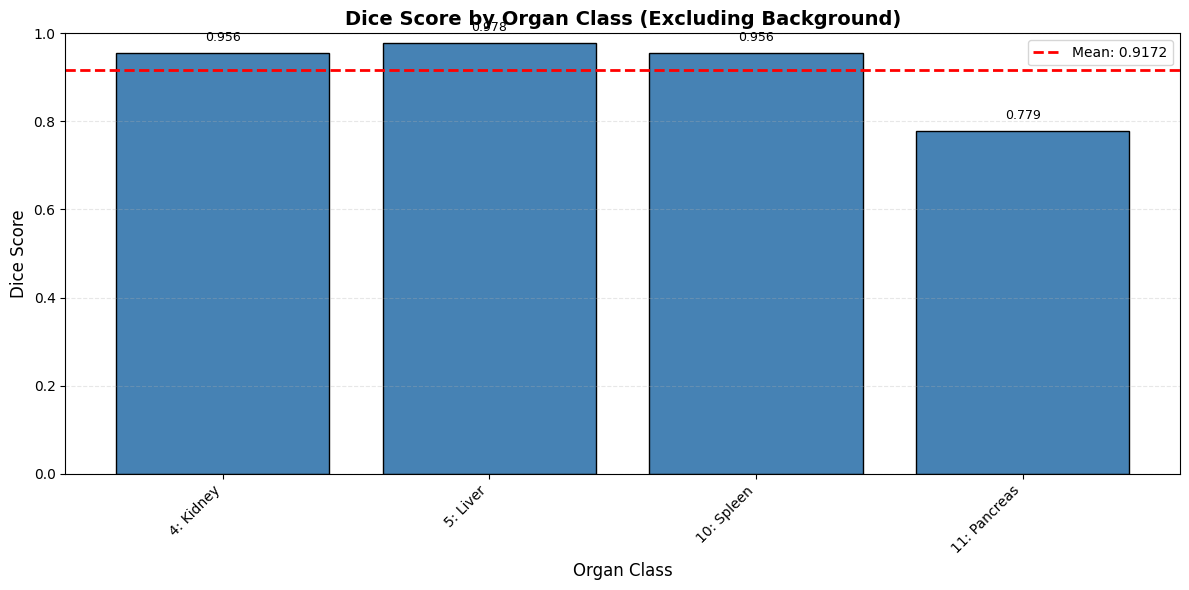

In [ ]:
# Calculate and visualize overall Dice scores for each organ class
label_dice_scores, mean_dice = calculate_and_visualize_dice_scores(
    mask_data, predicted_masks, num_classes, ORGAN_LABELS
)